# Intro
- This is the first jupyter notebook for the EIA interhemispheric assymmetry (IHA) seen during different solar cycles
- TEC comparison during the March equinox is carried out for different years
    - Peaks of the north and south EIA are traced and compared

# Reading New TEC Data and Producing Output Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il

from p_tqdm import p_map
from multiprocessing import Pool
import itertools

In [2]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [ ]:
functions = il.reload(functions)
month = 'sept' #'march'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'dec':
    years_tot = list(range(2000, 2024))
else:
    years_tot = list(range(2000, 2025))
    
for year in tqdm(years_tot):
    
    print(year)

    
    # Reading Madrigal Cedar data for +- 21 days around March equinox of 2010-2024
    # Files in below scratch folder are obtained by using multiple file download 
    # command in ASCII format and then doing `gunzip file.gz`  
    path = f'{scratch}Qingyu_Cesar_EIA/' + month + '_data/' + str(year) + '_' + month + '_' + phase + '/'
    files = os.listdir(path)
    files = [path + i for i in files]

    for f in files:
        if f[-4:] != '.txt':
            files.remove(f)
            
    print(len(files))
    
    tec_g = []
    columns = ['GDLAT', 'GLON', 'TEC', 'DT']
    grnd_tec = pd.DataFrame(columns=columns)
    
    def process_file(f):
        # Read function passed continuously during multiple processing to quicken the process
        df = pd.read_csv(f, sep=r'\s+')
        d = [dt.datetime(y, m, d, h, mi, s) for y, m, d, h, mi, s in zip(df.YEAR, df.MONTH, df.DAY, df.HOUR, df.MIN, df.SEC)]
        df['DT'] = d
        # Dropping unnecassary columns from the Dataframe
        df = df.drop(['RECNO', 'KINDAT', 'KINST', 'UT1_UNIX', 'UT2_UNIX', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'DTEC'], axis=1)
        if 'GDALT' in df.columns:
            df = df.drop(['GDALT'], axis=1)
        df = df[(df.GDLAT > -60) & (df.GDLAT < 60) & (df.GLON > -85) & (df.GLON < -45)].reset_index(drop=True)
        return df    
    # Speeding the process by using parallel processing
    tec_g = p_map(process_file, files)  # Parallel processing with progress bar
    print('1')
    grnd_tec = pd.concat(tec_g, axis=0).reset_index(drop=True)
    grnd_tec0 = grnd_tec.sort_values(by=['DT', 'GDLAT'], ascending=[True, True])


    # Reading the Kp index values for all the days and filtering undesired points where Kp > 3
    file = f'{work}Qingyu_Cesar_EIA_IHA/kp3_index_values/kp_{str(year)}_{month}.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    date_kp = [functions.day_to_date(i, year) for i in kp.DOY]
    m, d = zip(*date_kp)
    kp['date'] = [dt.datetime(year, j, i, k, 0, 0) for i,j,k in zip(d,m,kp.Hour)]
    kp['kp'] = [i/10 for i in kp.Kp]
    kp = kp.drop(['Year', 'DOY', 'Hour','Kp'], axis = 1)
    # the below command is messing up the kp values as it is trying to fit the kp value 
    # based on weighted average of all the known points surrounding it
    merged_data = pd.merge_asof(grnd_tec0.sort_values('DT'), kp.sort_values('date'), left_on='DT', right_on='date', direction='nearest')
    grnd_tec0 = merged_data.drop(['date'], axis = 1)
    print('2')

    # Calculation of magnetic coordinates by using Apex library and Parallel prcoessing 
    t_start = dt.datetime.now() # just a timer
    with Pool(20) as pool:
        p = pool.starmap(functions.magnetic_coords_parallel, zip(grnd_tec0.DT, grnd_tec0.GDLAT, grnd_tec0.GLON, grnd_tec0.TEC))
    pool.close()
    pool.join()
    # Separating the data from output list 
    sat_date, sat_glat, sat_glon, sat_tec, sat_mlat, sat_mlon, sat_mlt = zip(*p)
    


    # Reordering the outputs and applying further conditions on magnetic coordinates
    grnd_temp = pd.DataFrame({'DT': sat_date, 'GDLAT': sat_glat, 'GLON': sat_glon, 'TEC': sat_tec, 'MLAT': sat_mlat, 'MLON': sat_mlon, 'MLT': sat_mlt, 'kp':grnd_tec0.kp, 'f107':grnd_tec0['F10.7']})
    grnd_tec1 = grnd_temp.sort_values(by=['DT', 'GDLAT'], ascending=[True, True]).reset_index()
    grnd_tec1 = grnd_tec1[(grnd_tec1.MLON <= 5) & (grnd_tec1.MLON >= -5)].reset_index(drop=True)
    grnd_tec1 = grnd_tec1[(grnd_tec1.MLAT <= 40) & (grnd_tec1.MLAT >= -40)].reset_index(drop=True)
    grnd_tec2 = grnd_tec1.drop(['GDLAT', 'GLON','MLON'], axis = 1)

    
    # Writing the output into csv files for easy post processing
    grnd_tec2.to_csv(f'{scratch}Qingyu_Cesar_EIA/outputs/{month}/{str(year)}_{month}_{phase}.csv', index=False)

    t_total = dt.datetime.now() - t_start
    print(t_total)

# F10.7 Comparison for March 2023 and 2024

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import datetime as dt


In [ ]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 1

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/'
    scratch = '/home/pxv220017/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [ ]:
functions = il.reload(functions)
f107_years = [2023, 2024]
month = 'march'

path = f'{work}Qingyu_Cesar_EIA_IHA/outputs/{month}/f107_{month}_'

columns = ['Year', 'DOY', 'Hour', 'f10_7']
f107 = pd.DataFrame(columns = columns)

for y in f107_years:
    file = f'{path}{str(y)}.txt'
    df_f107 = pd.read_csv(file, sep=r'\s+')
    print(y, 'year -> Mean =', sum(df_f107.f10_7)/len(df_f107.f10_7), 'and Median =', np.median(df_f107.f10_7))
print('\nBoth mean and median of F10.7 index during ' + month + ' equinox for 2023 is higher than 2024.')

2023 year -> Mean = 150.87441860465202 and Median = 148.1
2024 year -> Mean = 146.01395348837212 and Median = 137.6

Both mean and median of F10.7 index during march equinox for 2023 is higher than 2024.


# Reading Data Directly From Saved Output Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
import datetime as dt
from scipy.signal import savgol_filter
import statistics
import seaborn as sns


In [2]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [ ]:
month = 'march' #'march'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'dec':
    years_tot = list(range(2000, 2024))
else:
    years_tot = list(range(2000, 2025))


for year in tqdm(years_tot):
    # Reading the data from output csv
    grnd_tec2 = pd.read_csv(f'{scratch}Qingyu_Cesar_EIA/outputs/{month}/{str(year)}_{month}_{phase}.csv')
    grnd_tec2 = grnd_tec2[grnd_tec2['TEC'] < 250].reset_index(drop=True)
    grnd_tec2 = grnd_tec2[grnd_tec2['kp'] <= 3].reset_index(drop=True)
    grnd_tec2 = grnd_tec2.drop(['kp'], axis = 1)
    
    
    # Define the bin edges for MLAT and MLT
    bins_mlat = pd.cut(grnd_tec2['MLAT'], bins=pd.interval_range(start=-40, end=40, freq=1))
    bins_mlt = pd.cut(grnd_tec2['MLT'], bins=pd.interval_range(start=0, end=24, freq=0.25))
    
    # Create a new DataFrame with the bins
    grnd_tec2['MLAT_b'] = bins_mlat
    grnd_tec2['MLT_b'] = bins_mlt
    
    # Group by the bins (MLAT_b (primary) and MLT_b (secondary)) and calculate the average of TEC
    grouped = grnd_tec2.groupby(['MLT_b', 'MLAT_b'], observed=False)['TEC']
    result = grouped.agg(
        mean=lambda x: x.mean(skipna=True),
        std=lambda x: x.std(skipna=True),
        min=lambda x: x.min(skipna=True),
        max=lambda x: x.max(skipna=True),
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75)
    ).reset_index()
    result = result.rename(columns={'mean':'TEC'})

    # Converting the midpoint values of bins to float and assigning average TEC at those points
    result['MLAT_b'] = result['MLAT_b'].apply(lambda x: x.mid)
    result['MLT_b'] = result['MLT_b'].apply(lambda x: x.mid)
    result['MLAT_b'] = result['MLAT_b'].astype(float)
    result['MLT_b'] = result['MLT_b'].astype(float)
    

    
    result = result[(result.MLT_b >= 11) & (result.MLT_b <= 20)].reset_index(drop=True)
    filtered = []
    for t in result['MLT_b'].unique():
        result_f = result[result['MLT_b'] == t].reset_index(drop=True)
        try:
            # Try applying the Savitzky-Golay filter
            fit = savgol_filter(np.array(result_f.TEC), 10, 2)
        except np.linalg.LinAlgError:
            print(f"SVD did not converge for MLT_b = {t}")
            fit = np.array(result_f.TEC)  # Use the raw data if filter fails
        #fit = savgol_filter(np.array(result_f.TEC), 10, 2)
        filtered.extend(fit)
    result['TEC'] = filtered
    result = result.groupby(['MLAT_b', 'MLT_b'], observed=False).sum().reset_index()
    
    
    # Identifying NH and SH peaks
    result_t = result[result.MLT_b >= 13].reset_index(drop=True)
    result_n = result_t[result_t.MLAT_b > 0].reset_index(drop=True)
    result_s = result_t[result_t.MLAT_b < 0].reset_index(drop=True)
    result_n = result_n.loc[result_n.groupby('MLT_b')['TEC'].idxmax()].reset_index(drop=True)
    result_s = result_s.loc[result_s.groupby('MLT_b')['TEC'].idxmax()].reset_index(drop=True)
    # Dropping the cases where the SH peak is not prominent and maxima appears to come at equator
    result_n.loc[result_n['MLAT_b'] < 5, 'TEC'] = np.nan
    result_s.loc[result_s['MLAT_b'] > -5, 'TEC'] = np.nan
    #print(result_s)

    i = 100*2*(result_n.TEC - result_s.TEC)/(result_n.TEC + result_s.TEC)
    result_ind = pd.DataFrame({'mlat_n': result_n['MLAT_b'], 'tec_n': result_n['TEC'], 'tec_min_n': result_n['min'], 
                               'tec_max_n': result_n['max'], 'tec_q25_n': result_n['q25'], 'tec_q75_n': result_n['q75'],
                               'tec_std_n': result_n['std'], 'mlat_s': result_s['MLAT_b'], 'tec_s': result_s['TEC'], 
                               'tec_min_s': result_s['min'], 'tec_max_s': result_s['max'], 'tec_q25_s': result_s['q25'], 
                               'tec_q75_s': result_s['q75'], 'tec_std_s': result_n['std'], 'mlt': result_n['MLT_b'], 'asy': i})
    result_ind.to_csv(f'{work}Qingyu_Cesar_EIA_IHA/outputs/{month}/asy_{str(year)}_{month}.csv', index=False)


    # Creating new dataframe to remove rows where TEC= NaN
    result_n = pd.DataFrame({'mlt': result_ind.mlt, 'mlat_n': result_ind.mlat_n, 'tec_n': result_ind.tec_n})
    result_n = result_n.dropna(subset='tec_n')
    result_s = pd.DataFrame({'mlt': result_ind.mlt, 'mlat_s': result_ind.mlat_s, 'tec_s': result_ind.tec_s})
    result_s = result_s.dropna(subset='tec_s')
    # Set ColumnB to NaN where ColumnA is NaN
    result_ind.loc[result_ind['tec_n'].isna(), ['tec_min_n', 'tec_q25_n', 'tec_q75_n', 'tec_max_n']] = np.nan
    result_ind.loc[result_ind['tec_s'].isna(), ['tec_min_s', 'tec_q25_s', 'tec_q75_s', 'tec_max_s']] = np.nan
        

    file = f'{work}Qingyu_Cesar_EIA_IHA/kp3_index_values/kp_{str(year)}_{month}.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    f10_mean = sum(kp['F10.7'])/len(kp['F10.7'])
    f10_med = statistics.median(kp['F10.7'])
    
    
    # Plotting the TEC plots
    X, Y = np.meshgrid(result.MLT_b.unique(), result.MLAT_b.unique())
    Z = result.TEC.values.reshape(X.shape)
    Z = np.ma.masked_where(Z == 0, Z)
    
    fig = plt.figure(figsize=(12, 12))  # Increased figure height to accommodate three rows
    specs = fig.add_gridspec(3, 2, width_ratios=[1, 0.025], height_ratios=[1, 0.5, 0.5])  # Added a third row, adjusted height ratios
    
    # First plot - TEC Contour
    ax1 = fig.add_subplot(specs[0, 0])
    if np.max(Z) <= 20:
        contour_levels = list(range(0, 21, 5))
    elif np.max(Z) <= 40:
        contour_levels = list(range(0, 41, 5))
    elif np.max(Z) <= 60:
        contour_levels = list(range(0, 61, 5))
    elif np.max(Z) <= 80:
        contour_levels = list(range(0, 81, 5))
    elif np.max(Z) <= 100:
        contour_levels = list(range(0, 101, 5))
    elif np.max(Z) <= 120:
        contour_levels = list(range(0, 121, 5))
    elif np.max(Z) <= 140:
        contour_levels = list(range(0, 141, 5))
    elif np.max(Z) <= 160:
        contour_levels = list(range(0, 161, 5))
    
    c = ax1.contourf(X, Y, Z, levels=contour_levels, cmap='jet')
    ax1.scatter(result_n.mlt, result_n.mlat_n, c='b', s=30)
    ax1.scatter(result_s.mlt, result_s.mlat_s, c='b', s=30)
    ax1.set_title(f'Tracing EIA Peaks - {str(year)} {month} {phase} (F10.7 mean={str(f10_mean)[:5]}, median={str(f10_med)})')
    ax1.set_ylabel('MLAT')
    ax1.grid(True)
    ax1.set_xticklabels([])  # Hide x-ticks for ax1
    
    if np.max(Z) <= 40:
        ax1.set_ylim(top=40)
    
    cbar_ax = fig.add_subplot(specs[0, 1])
    cbar = fig.colorbar(c, cax=cbar_ax, label='VTEC (TECUnits)', extend='both')
    
    # Second plot - Box and Whiskers
    ax2 = fig.add_subplot(specs[1, 0])  # Share x-axis with ax1
    for idx, (i, mean, min_val, max_val, q25, q75) in enumerate(zip(result_ind['mlt'], result_ind['tec_n'], result_ind['tec_min_n'], result_ind['tec_max_n'], result_ind['tec_q25_n'], result_ind['tec_q75_n'])):
        ax2.plot([i, i], [q25, q75], color='black', lw=1.5)
        ax2.plot([i - 0.05, i + 0.05], [q25, q25], color='black', lw=1.5)
        ax2.plot([i - 0.05, i + 0.05], [q75, q75], color='black', lw=1.5)
        ax2.plot(i, mean, 'ro', label='NH Peak' if idx == 0 else "") 
    
    for idx, (i, mean, min_val, max_val, q25, q75) in enumerate(zip(result_ind['mlt'], result_ind['tec_s'], result_ind['tec_min_s'], result_ind['tec_max_s'], result_ind['tec_q25_s'], result_ind['tec_q75_s'])):
        i = i + 0.125
        ax2.plot([i, i], [q25, q75], color='black', lw=1.5)
        ax2.plot([i - 0.05, i + 0.05], [q25, q25], color='black', lw=1.5)
        ax2.plot([i - 0.05, i + 0.05], [q75, q75], color='black', lw=1.5)
        ax2.plot(i, mean, 'bo', label='SH Peak' if idx == 0 else "")
    
    ax2.legend()
    ax2.set_xlim(11, 20)
    ax2.set_ylabel('TEC')
    ax2.grid(True)
    ax2.set_xticklabels([])  # Hide x-ticks for ax2
    
    # Third plot - ASY Plot
    ax3 = fig.add_subplot(specs[2, 0])  # Share x-axis with ax1
    ax3.plot(result_ind.mlt, result_ind.asy, color='black', label='ASY index')
    ax3.scatter(result_ind.mlt, result_ind.asy, color='black')
    ax3.axhline(y=0, color='red', linestyle=':')
    ax3.set_ylim(-30, 30)
    ax3.set_xlim(11, 20)
    ax3.set_ylabel('ASY Index')
    ax3.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
    ax3.set_xlabel('MLT')  # Keep x-label and x-ticks visible for the bottom plot
    ax3.grid(True)
    ax3.legend()
    mlt_filtered = result_ind.mlt[(result_ind.mlt >= 11) & (result_ind.mlt <= 20)]
    
    # Adjust layout: remove space between plots but ensure bottom x-ticks are visible
    plt.subplots_adjust(hspace=0)  # No vertical space between subplots
    plt.tight_layout()
    fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/eia_peaks/{month}/box_plot_peaks/tec_peaks_{month}_{str(year)}.jpg')
    plt.show()

    '''
    # Observing TEC values at 15 MLT on MLAT vs TEC plot
    result_c = result[(result.MLT_b >= hr-0.5) & (result.MLT_b <= hr+0.5)].reset_index(drop=True)
    plt.figure(figsize=(12,4))
    plt.scatter(result_c.MLAT_b, result_c.TEC)
    plt.title(f'TEC values at {hr} MLT of {year} {month} {phase}')
    plt.xlabel('MLAT')
    plt.ylabel('TEC')
    plt.show()
    ''';

'march'

In [85]:
month = 'march'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'dec' or month == 'sept':
    years_tot = list(range(2000, 2024))
else:
    years_tot = list(range(2000, 2025))


# Creating separate dataset for whisker plot variations of each day of each year at fixed time
hr = 21
mlt_yr_cmp = []

for year in tqdm(years_tot):
    # Reading the data from output csv
    grnd_tec2 = pd.read_csv(f'{scratch}Qingyu_Cesar_EIA/outputs/{month}/{str(year)}_{month}_{phase}.csv')
    grnd_tec2 = grnd_tec2[grnd_tec2['TEC'] < 250].reset_index(drop=True)
    #print(grnd_tec2[grnd_tec2.DOY == 60])


    start_time = pd.to_datetime(f'{hr-1}:30:00').time()
    end_time = pd.to_datetime(f'{hr}:30:00').time()
    '''
    print(list((grnd_tec0[(grnd_tec0['DT'].dt.time >= start_time) & 
                         (grnd_tec0['DT'].dt.time <= end_time) 
                         ].kp)))
    '''
    
    grnd_tec2['DT'] = pd.to_datetime(grnd_tec2['DT'], errors='coerce')
    result_hr = grnd_tec2[(grnd_tec2['MLT'] > hr - 0.5) & (grnd_tec2['MLT'] < hr + 0.5)].reset_index(drop=True)
    result_hr['DOY'] = result_hr['DT'].dt.dayofyear
    result_hr = result_hr.drop(['DT', 'MLT', 'index'], axis=1)
    result_hr.loc[result_hr['DOY'] < 40, 'DOY'] += 365
    #print(result_hr[result_hr.DOY == 60])


    
    # Define the bin edges for MLAT and MLT
    bins_mlat = pd.cut(result_hr['MLAT'], bins=pd.interval_range(start=-40, end=40, freq=1))
    result_hr['MLAT_b'] = bins_mlat

    result_hr = result_hr.groupby(['DOY', 'MLAT_b'], observed=True).agg(
        TEC=('TEC', lambda x: x.mean(skipna=True)),
        std=('TEC', lambda x: x.std(skipna=True)),
        min=('TEC', lambda x: x.min(skipna=True)),
        max=('TEC', lambda x: x.max(skipna=True)),
        q25=('TEC', lambda x: x.quantile(0.25)),
        q75=('TEC', lambda x: x.quantile(0.75)),
        kp=('kp', lambda x: x.mean(skipna=True))
    ).reset_index()
    #result_hr = result_hr.rename(columns={'mean':'TEC'})
    #print(len(result_hr[result_hr['DOY'] == 60].kp), list(result_hr[result_hr['DOY'] == 60].kp))

    
    '''
    plt.figure(figsize=(12,8))
    plt.plot(new)
    plt.plot(result_hr[result_hr['DOY'] == 60].TEC)
    plt.show()
    '''
    
    # Converting the midpoint values of bins to float and assigning average TEC at those points
    result_hr['MLAT_b'] = result_hr['MLAT_b'].apply(lambda x: x.mid)
    result_hr['MLAT_b'] = result_hr['MLAT_b'].astype(float)

    '''
    # Pivot the data to create a 2D grid for contour plotting
    grid = result_hr.pivot_table(index='MLAT_b', columns='DOY', values='TEC')    
    x = grid.columns.values  # DOY values
    y = grid.index.values    # MLAT_b values
    X, Y = np.meshgrid(x, y) # Meshgrid for contour plotting
    Z = grid.values          # TEC values

    plt.figure(figsize=(12, 4))
    contour = plt.contourf(X, Y, Z, cmap='jet')  # You can adjust the colormap
    cbar = plt.colorbar(contour)
    cbar.set_label('TEC')
    plt.xlabel('DOY')
    plt.ylabel('MLAT_b')
    plt.title('TEC Contour Plot')
    plt.show()
    '''

    mlt_yr_cmp.append(result_hr)

100%|███████████████████████████████████████████| 25/25 [03:40<00:00,  8.82s/it]


# All Correct b4 this

In [34]:
month = 'march'
phase = 'equinox'

if month == 'dec':
    years = range(2000, 2024)
else:
    years = range(2000, 2025)

kp_new = []

for year in tqdm(years):   
    
    file = f'{work}Qingyu_Cesar_EIA_IHA/kp3_index_values/kp_{str(year)}_{month}.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    kp.loc[kp['DOY'] < 40, 'DOY'] += 365
    kp['kp'] = [i/10 for i in kp['Kp']]
    
    file = f'{scratch}Qingyu_Cesar_EIA/outputs/{month}/{str(year)}_{month}_{phase}.csv'
    grnd_tec0 = pd.read_csv(file)
    grnd_tec0['kp_old'] = grnd_tec0.kp

    day = []
    mon = []
    for i,j in zip(kp.DOY, kp.Year):
        m, d = functions.day_to_date(i, j)
        day.append(d)
        mon.append(m)

    kp['DT'] = [dt.datetime(int(y), int(m), int(d), int(h), 0, 0) for y,m,d,h in zip(kp.Year, mon, day, kp.Hour)]
    grnd_tec0['DT'] = pd.to_datetime(grnd_tec0['DT'])
    kp['DT'] = pd.to_datetime(kp['DT'])
    print('kp \n', kp[kp.Hour == 15])

    print(grnd_tec0)
    target_date = '2012-02-29'
    start_time = pd.to_datetime('14:30:00').time()
    end_time = pd.to_datetime('15:30:00').time()
    '''
    print(list((grnd_tec0[(grnd_tec0['DT'].dt.time >= start_time) & 
                         (grnd_tec0['DT'].dt.time <= end_time) & 
                         (grnd_tec0['DT'].dt.date == pd.to_datetime(target_date).date())
                         ].kp)))
    '''
    
    kp_filtered = kp[['DT', 'kp', 'DOY', 'F10.7']].sort_values('DT')
    merged = pd.merge_asof(grnd_tec0.sort_values('DT'), kp_filtered, on='DT', direction='nearest')
    
    merged['kp'] = merged.kp_y
    merged['DOY'] = merged.DOY_y
    merged = merged.drop(['kp_x', 'kp_y', 'kp_old', 'DOY_x', 'DOY_y'], axis = 1)    
    print('merged \n', merged)
    merged.to_csv(f'{scratch}Qingyu_Cesar_EIA/outputs/{month}/{str(year)}_{month}_{phase}.csv', index=False)


    '''
    print(((merged[(merged['DT'].dt.time >= start_time) & 
                         (merged['DT'].dt.time <= end_time) & 
                         (merged['DT'].dt.date == pd.to_datetime(target_date).date())
                         ])))
    
    

    merged1 = merged[merged['DOY'] == 60]
    plt.figure(figsize=(12,8))
    plt.plot(merged1.DT, merged1.kp_x, label = 'wrong, backward')
    plt.plot(merged1.DT, merged1.kp_y, label = 'right, nearest')
    plt.plot(merged1.DT, merged1.kp_old + 0.25, label = 'wrong, stored')
    plt.legend()
    plt.show()

    kp = kp[kp['DOY'] == 60]
    plt.figure(figsize=(12,8))
    plt.plot(kp.DT, kp.kp)
    plt.scatter(kp.DT, kp.kp)
    plt.show()


    merged2 = merged.groupby('DOY')[['kp_old']].mean().reset_index()
    print('merged2 \n', merged2)
    plt.figure()
    plt.plot(merged2.kp_old)
    '''
    break
    

  0%|                                                    | 0/13 [00:00<?, ?it/s]

kp 
       Year  DOY  Hour  Kp  F10.7   kp                  DT
15    2012   60    15   3  100.2  0.3 2012-02-29 15:00:00
39    2012   61    15  27  101.6  2.7 2012-03-01 15:00:00
63    2012   62    15  20  106.3  2.0 2012-03-02 15:00:00
87    2012   63    15  27  114.5  2.7 2012-03-03 15:00:00
111   2012   64    15  17  118.2  1.7 2012-03-04 15:00:00
135   2012   65    15  17  129.5  1.7 2012-03-05 15:00:00
159   2012   66    15  20  136.0  2.0 2012-03-06 15:00:00
183   2012   67    15  53  133.7  5.3 2012-03-07 15:00:00
207   2012   68    15  47  137.5  4.7 2012-03-08 15:00:00
231   2012   69    15  57  143.5  5.7 2012-03-09 15:00:00
255   2012   70    15  30  146.9  3.0 2012-03-10 15:00:00
279   2012   71    15  27  129.5  2.7 2012-03-11 15:00:00
303   2012   72    15  37  113.5  3.7 2012-03-12 15:00:00
327   2012   73    15  17  139.0  1.7 2012-03-13 15:00:00
351   2012   74    15  30  117.5  3.0 2012-03-14 15:00:00
375   2012   75    15  63  109.4  6.3 2012-03-15 15:00:00
399   201

  0%|                                                    | 0/13 [00:38<?, ?it/s]


  0%|                                                     | 0/6 [00:00<?, ?it/s]

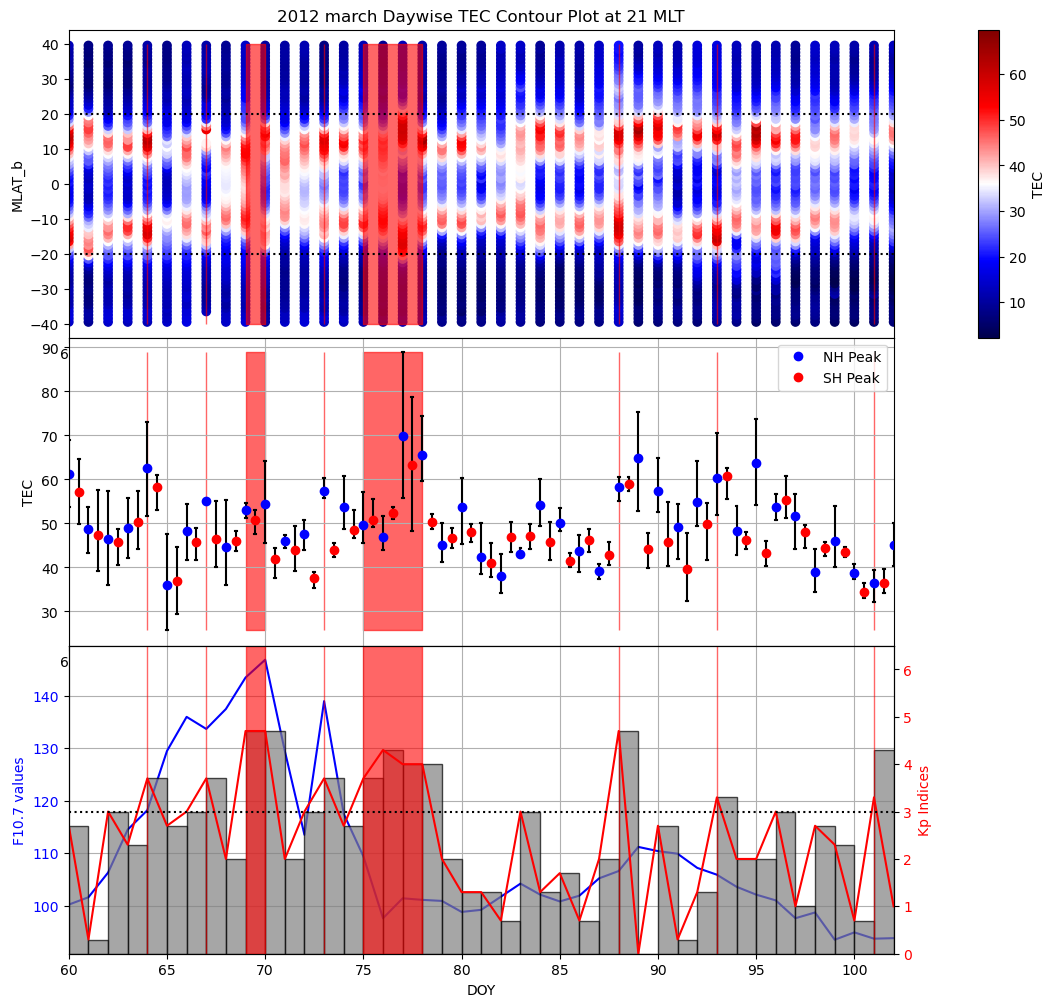

 17%|███████▌                                     | 1/6 [00:01<00:09,  1.85s/it]

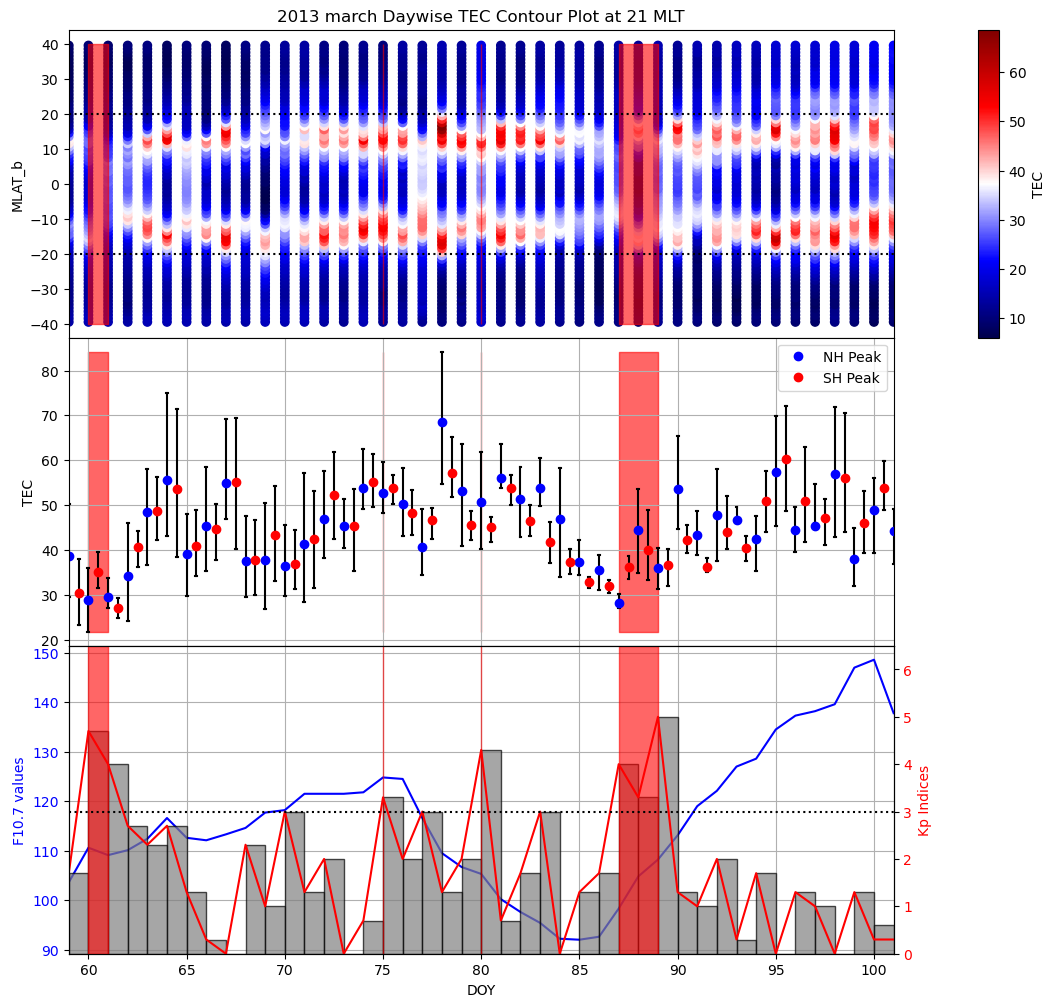

 33%|███████████████                              | 2/6 [00:03<00:06,  1.56s/it]

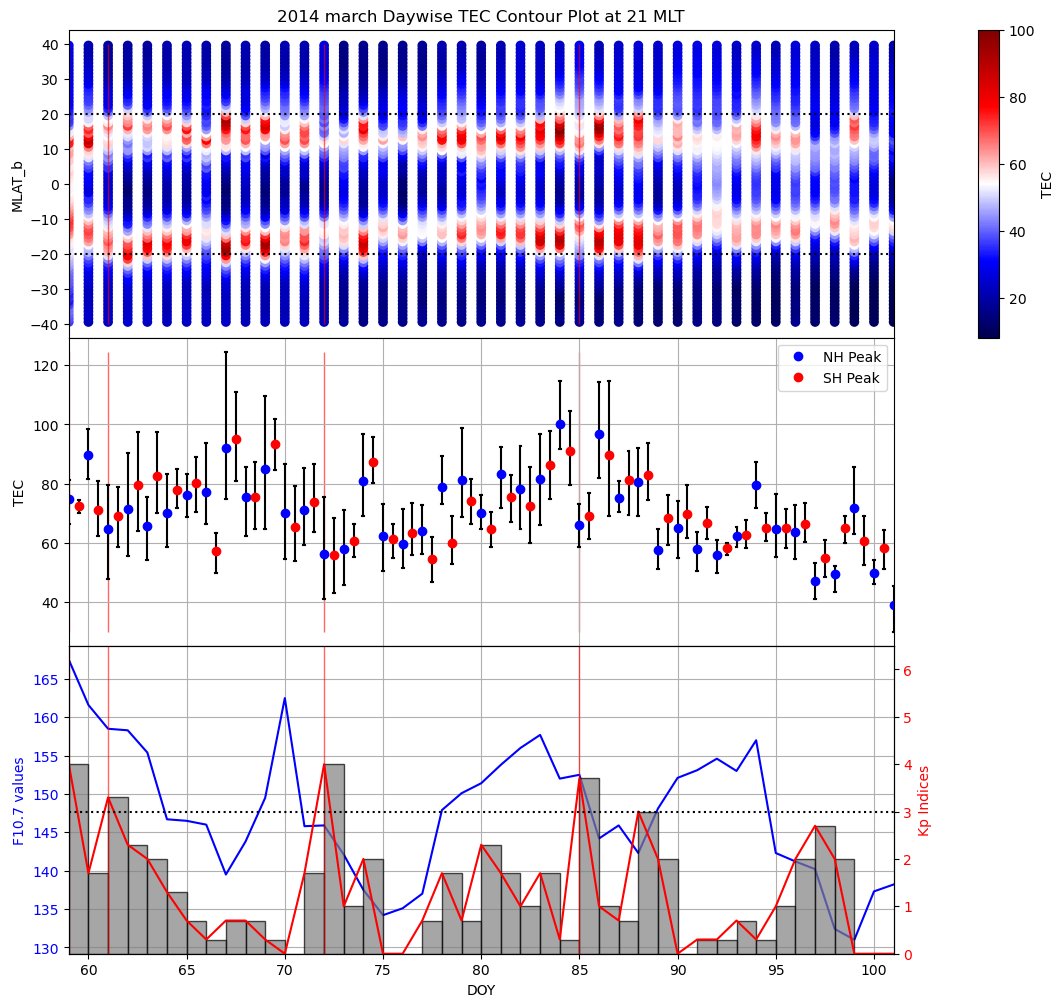

 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.46s/it]

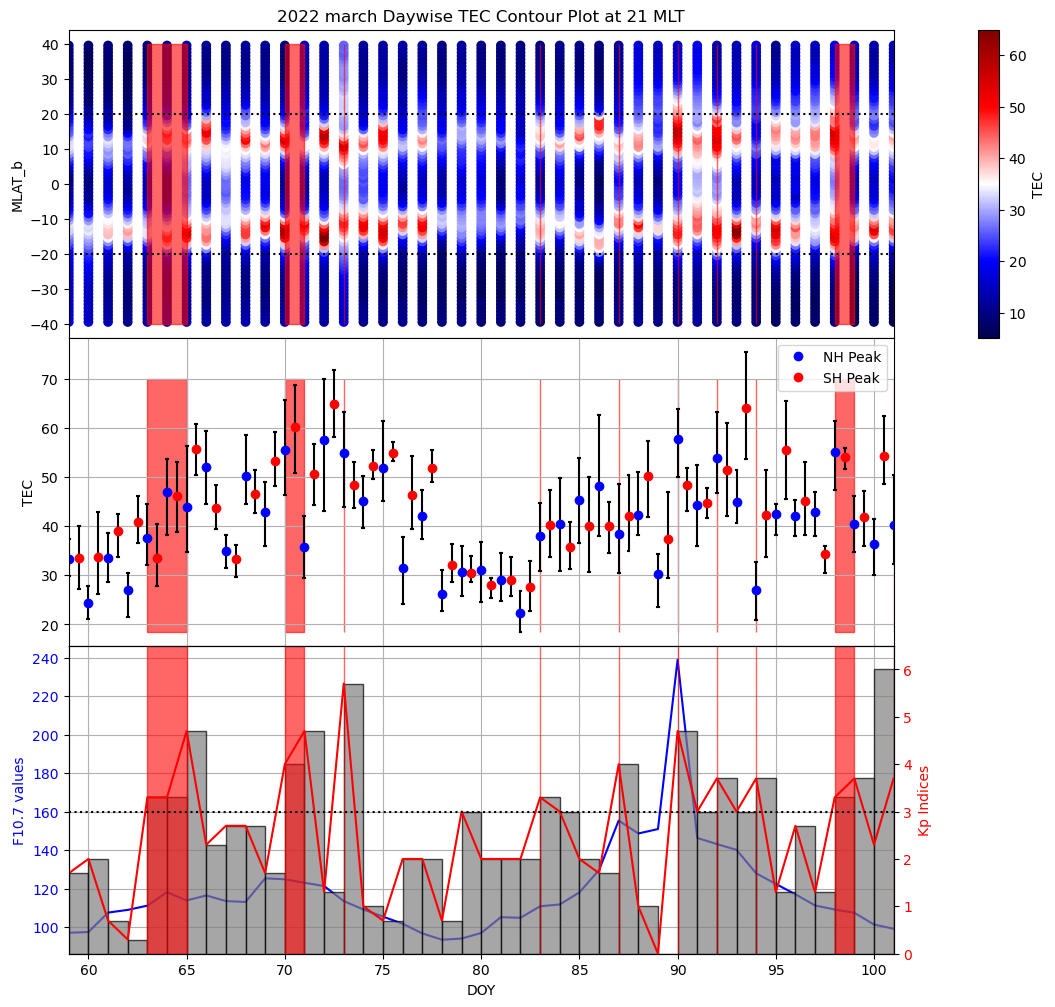

 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.42s/it]

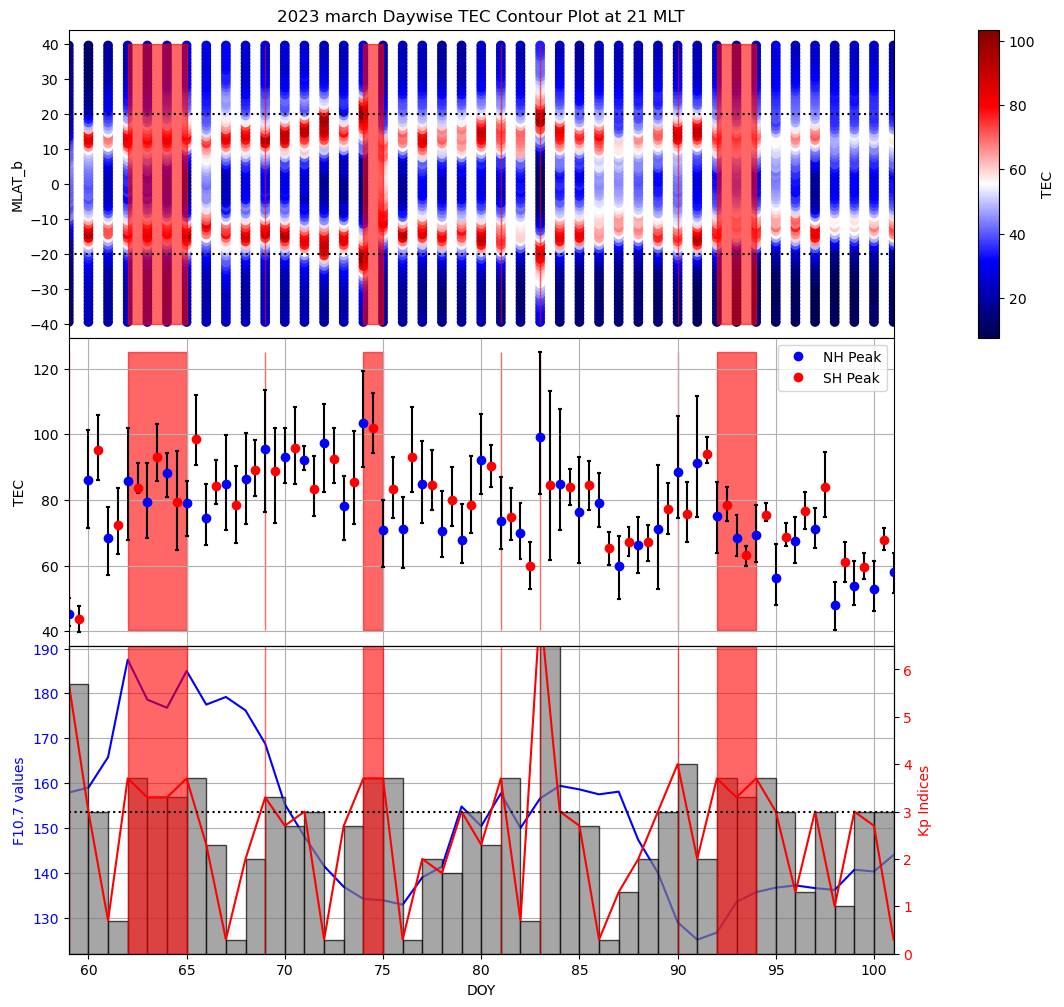

 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.42s/it]

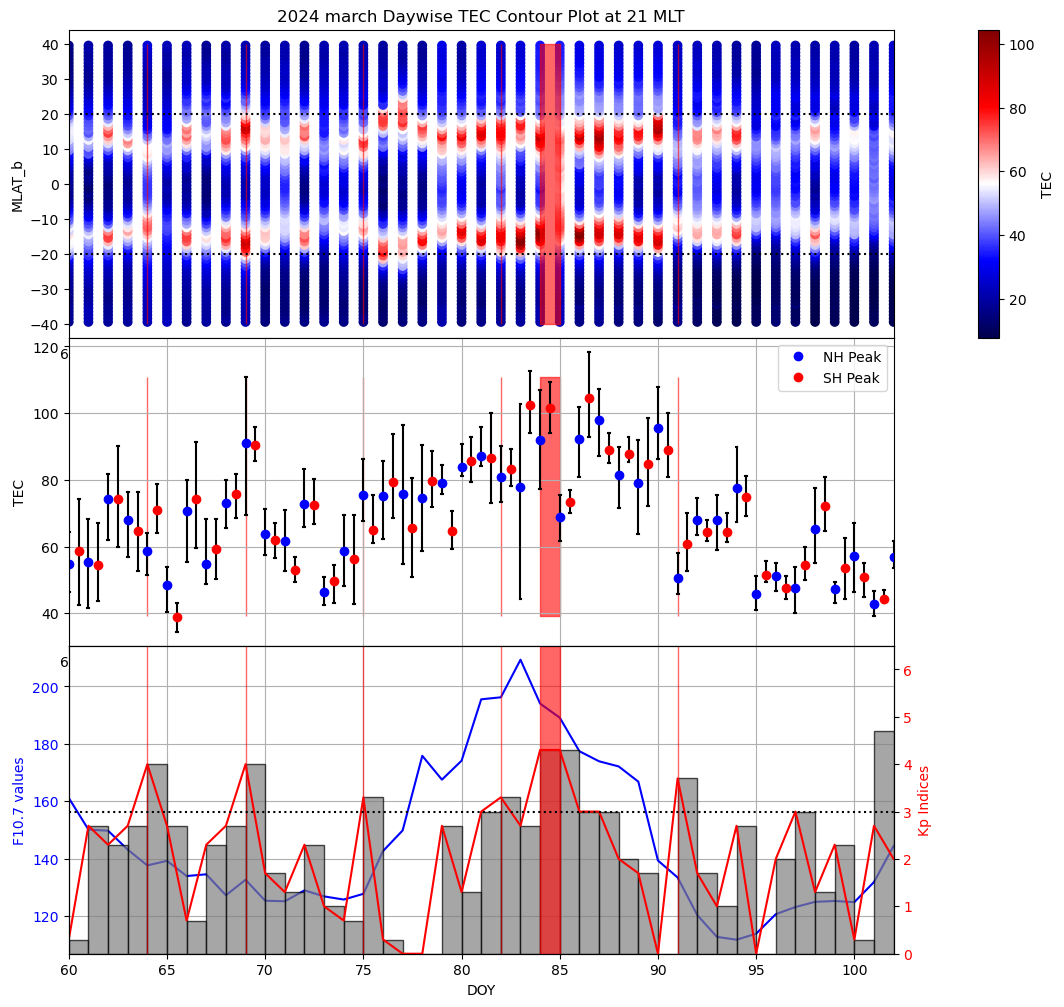

100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.44s/it]


In [90]:

if month == 'dec':
    years = [2012, 2013, 2014, 2022, 2023]
else:
    years = [2012, 2013, 2014, 2022, 2023, 2024]
    
for y in tqdm(years):
    i = y - 2000
    result_hr = mlt_yr_cmp[i]
    
    
    file = f'{work}Qingyu_Cesar_EIA_IHA/kp3_index_values/kp_{str(y)}_{month}.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    kp['kp'] = [i/10 for i in kp['Kp']]

    kp['mlt'] = [(i-3)%24 for i in kp.Hour]
    kp = kp[kp.mlt == hr].reset_index(drop=True)
    #print(kp)
    #kp = kp.groupby('DOY')[['kp', 'F10.7']].mean().reset_index()
    kp.loc[kp['DOY'] < 40, 'DOY'] += 365
    
    #print('kp \n', kp)
    result_hr1 = result_hr #.groupby('DOY')['kp'].mean().reset_index()
    #print('result_hr1 \n', result_hr1)


    '''
    plt.figure()
    plt.plot(kp.DOY, kp.kp, label='kp')
    plt.plot(result_hr.DOY, result_hr.kp, label='result_hr')
    plt.legend()
    plt.show()
    '''
    
    north_max_val = result_hr[result_hr['MLAT_b'] > 5].groupby('DOY')['TEC'].idxmax()
    south_max_val = result_hr[result_hr['MLAT_b'] < -5].groupby('DOY')['TEC'].idxmax()
    north_max_val = north_max_val.dropna()
    south_max_val = south_max_val.dropna()
    max_north = result_hr.loc[north_max_val]
    max_south = result_hr.loc[south_max_val]

    
    # Create a figure
    fig = plt.figure(figsize=(12, 12))
    gs = fig.add_gridspec(3, 2, width_ratios=[1, 0.025], height_ratios=[1, 1, 1], hspace=0)  # Adjust width ratio for colorbar
    
    
    # First plot (Scatter plot for TEC) on the first row
    ax1 = fig.add_subplot(gs[0, 0])  # First column for the scatter plot
    sc = ax1.scatter(result_hr.DOY, result_hr.MLAT_b, c=result_hr.TEC, cmap='seismic')  # Adjust the colormap
    ax1.set_ylabel('MLAT_b')
    ax1.set_title(f'{y} {month} Daywise TEC Contour Plot at {hr} MLT')
    ax1.axhline(y=20, color='black', linestyle=':')
    ax1.axhline(y=-20, color='black', linestyle=':')
    ax1.fill_between(kp.DOY, -40, 40, 
                where=(kp.kp > 3),
                color='red', alpha=0.6)

    # Add a colorbar in the second column of the first row
    cbar_ax = fig.add_subplot(gs[0, 1])  # Second column for the colorbar
    cbar = fig.colorbar(sc, cax=cbar_ax)
    cbar.set_label('TEC')

    
    # Second plot (Box plot for TEC Peaks) on the second row
    ax2 = fig.add_subplot(gs[1, 0])  # First column for the box plot
    for idx, (i, mean, min_val, max_val, q25, q75) in enumerate(zip(max_north['DOY'], max_north['TEC'], max_north['min'], max_north['max'], max_north['q25'], max_north['q75'])):
        ax2.plot([i, i], [q25, q75], color='black', lw=1.5)  # Box line
        ax2.plot([i - 0.05, i + 0.05], [q25, q25], color='black', lw=1.5)  # Lower cap
        ax2.plot([i - 0.05, i + 0.05], [q75, q75], color='black', lw=1.5)  # Upper cap
        ax2.plot(i, mean, 'bo', label='NH Peak' if idx == 0 else "")  # Mean point
        
    for idx, (i, mean, min_val, max_val, q25, q75) in enumerate(zip(max_south['DOY'], max_south['TEC'], max_south['min'], max_south['max'], max_south['q25'], max_south['q75'])):
        i += 0.5
        ax2.plot([i, i], [q25, q75], color='black', lw=1.5)  # Box line
        ax2.plot([i - 0.05, i + 0.05], [q25, q25], color='black', lw=1.5)  # Lower cap
        ax2.plot([i - 0.05, i + 0.05], [q75, q75], color='black', lw=1.5)  # Upper cap
        ax2.plot(i, mean, 'ro', label='SH Peak' if idx == 0 else "")  # Mean point
    
    ax2.fill_between(kp.DOY, max_north['q25'].min(), max_north['q75'].max(), 
                 where=(kp.kp > 3),
                 color='red', alpha=0.6)
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylabel('TEC')


    # Third plot (F10.7 values) on the third row
    ax3 = fig.add_subplot(gs[2, 0])  # First column for the F10.7 plot
    ax3.plot(kp.DOY, kp['F10.7'], color = 'blue', linestyle ='-', label='F10.7')
    ax3.set_ylabel('F10.7 values', color='blue')
    ax3.tick_params(axis='y', labelcolor='blue')
    ax4 = ax3.twinx()
    ax4.plot(kp.DOY, kp.kp, label='Kp Index', color='red')
    ax4.hist(kp.DOY, bins=range(min(kp.DOY), max(kp.DOY)+1), weights=kp.kp, color='gray', alpha=0.7, edgecolor='black', align='mid')
    ax4.tick_params(axis='y', labelcolor='red')
    ax4.set_ylabel('Kp Indices', color='red')
    ax3.grid(True)
    # there will be difference between kp.kp and result_hr.kp as result_hr is not averaged along all the mlats yet and is thus of larger length that kp.kp
    ax4.fill_between(kp.DOY, 0, 6.5, 
                 where=(kp.kp > 3),
                 color='red', alpha=0.6)
    ax4.set_ylim(0, 6.5)
    ax4.axhline(y=3, color='black', linestyle=':')
    
    # Set the same x-label for all plots
    ax3.set_xlabel('DOY')
    
    # Adjust layout to remove space between plots
    plt.subplots_adjust(hspace=0)

    common_xlim = (result_hr.DOY.min(), result_hr.DOY.max())
    ax1.set_xlim(common_xlim)
    ax2.set_xlim(common_xlim)
    ax3.set_xlim(common_xlim)
    ax4.set_xlim(common_xlim)

    # Save the figure if needed
    fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/eia_peaks/{month}/box_plot_peaks/doy_mlat_{month}_{str(year)}.jpg')

    # Show the plots
    plt.show()


    '''
    # plot to verify the appearance of EIA at individual day of result_hr     
    average_tec_per_mlat = result_hr.groupby('MLAT_b', observed=False)['TEC'].mean().reset_index()
    fit = savgol_filter(np.array(average_tec_per_mlat.TEC), 5, 1)
    plt.figure(figsize=(12,4))
    plt.plot(average_tec_per_mlat.MLAT_b, fit)
    plt.show()
    ''';

# Comparing Asymmetry Index

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import datetime as dt


In [4]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 2

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [5]:
month = 'sept' # 'march'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'sept' or month == 'dec':
    years = list(range(2006, 2009)) + list(range(2017, 2020)) + list(range(2000, 2003)) + list(range(2012, 2015)) + list(range(2022, 2024))
else:
    years = list(range(2006, 2009)) + list(range(2017, 2020)) + list(range(2000, 2003)) + list(range(2012, 2015)) + list(range(2022, 2025))


asy_ind = []

for y in years:
    f = pd.read_csv(f'{work}Qingyu_Cesar_EIA_IHA/outputs/{month}/asy_{str(y)}_{month}.csv')
    asy_ind.append(f)

0it [00:00, ?it/s]

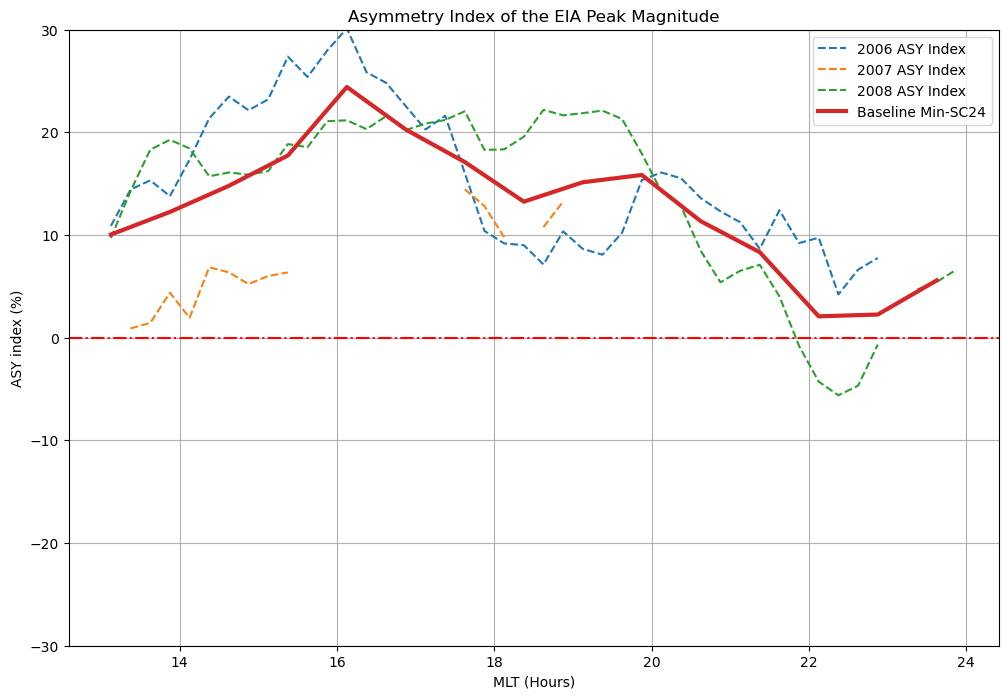

1it [00:00,  2.70it/s]

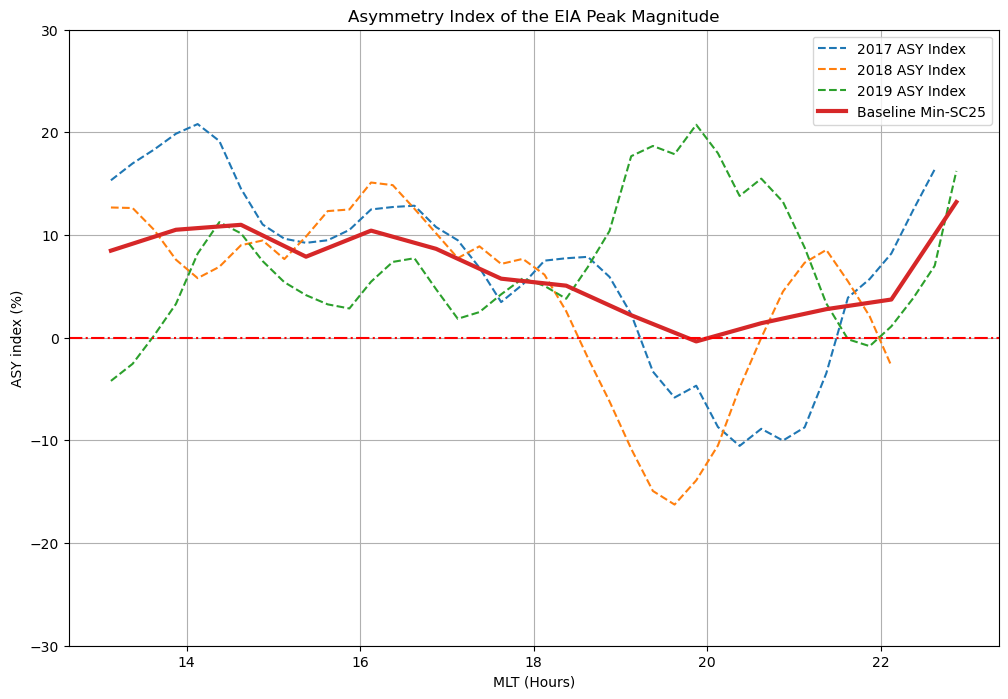

2it [00:00,  3.04it/s]

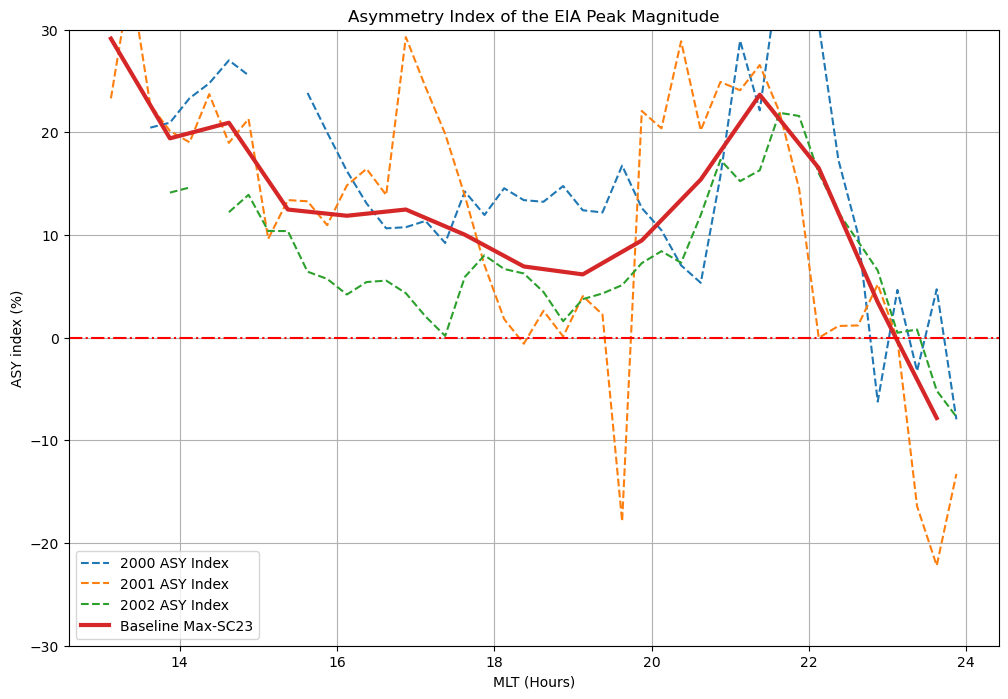

3it [00:00,  3.16it/s]

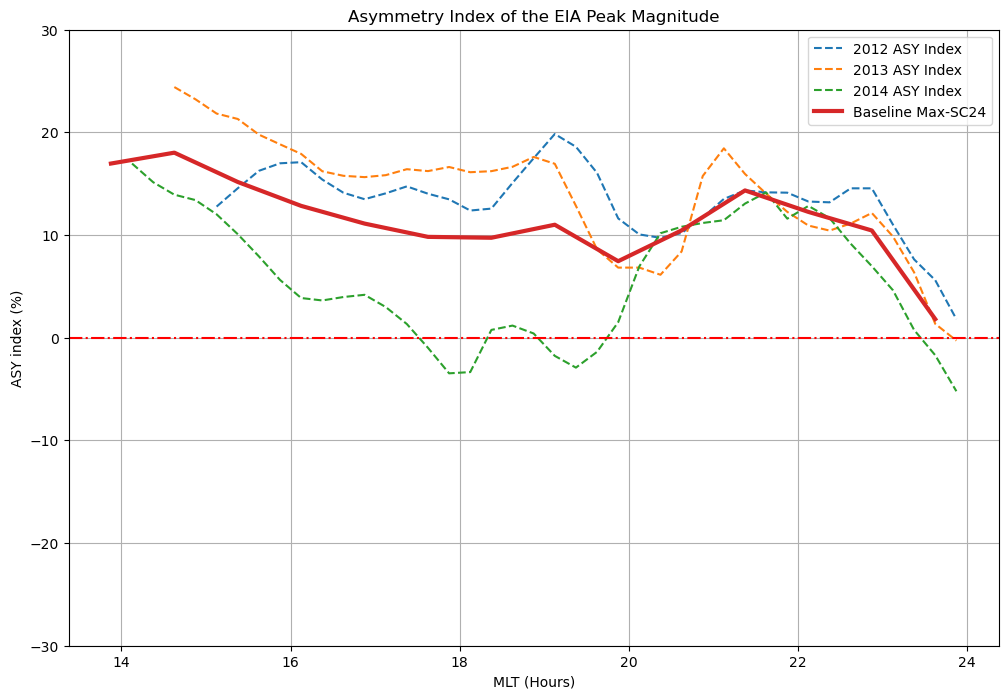

4it [00:01,  3.22it/s]

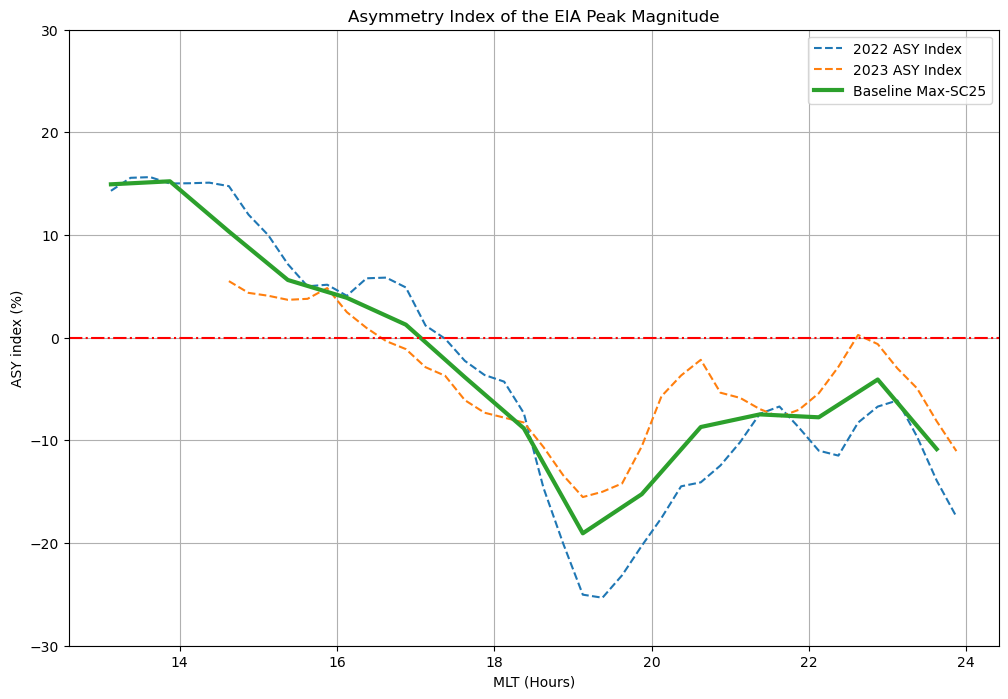

5it [00:01,  3.20it/s]


In [6]:
if month == 'sept' or month == 'dec':
    solar_cyc = [[list(range(2006, 2009))], [list(range(2017, 2020))], [list(range(2000, 2003))], [list(range(2012, 2015))], [list(range(2022, 2024))]]
else:
    solar_cyc = [[list(range(2006, 2009))], [list(range(2017, 2020))], [list(range(2000, 2003))], [list(range(2012, 2015))], [list(range(2022, 2025))]]


sc = ['Baseline Min-SC24', 'Baseline Min-SC25', 'Baseline Max-SC23', 'Baseline Max-SC24', 'Baseline Max-SC25']

sc_base = []

for s, n in tqdm(zip(solar_cyc, sc)):

    fig = plt.figure(figsize=(12,8))

    for periods in s:
        columns = ['mlt', 'asy']
        baseline = pd.DataFrame(columns=columns)

        for p in periods:
            a = pd.read_csv(f'{work}/Qingyu_Cesar_EIA_IHA/outputs/{month}/asy_{str(p)}_{month}.csv')
            a = a.drop(['mlat_n', 'mlat_s', 'tec_n', 'tec_s'], axis=1)
            #a = a.dropna(subset = 'asy')
            baseline = pd.concat([baseline, a], axis=0).reset_index(drop=True)
            plt.plot(a.mlt, a.asy, linestyle = '--', label = f'{str(p)} ASY Index')
        
        baseline = baseline.sort_values(by=['mlt'], ascending=[True])
        bins_mlt = pd.cut(baseline['mlt'], bins=pd.interval_range(start=0, end=24, freq=0.75))
        baseline['mlt'] = bins_mlt
        baseline = baseline.groupby(['mlt'])['asy'].mean().reset_index()
        baseline['mlt'] = baseline['mlt'].apply(lambda x: x.mid)
        baseline['mlt'] = baseline['mlt'].astype(float)
        baseline.dropna(inplace=True)
        plt.plot(baseline.mlt, baseline.asy, label=n, linewidth=3)
        break
    
    plt.ylim(-30,30)
    plt.axhline(y=0, color='red', linestyle='-.')
    plt.legend()
    plt.title('Asymmetry Index of the EIA Peak Magnitude')
    plt.ylabel('ASY index (%)')
    plt.xlabel('MLT (Hours)')
    plt.grid(True)
    fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/{n[-8:]}_{month}.jpg')
    plt.show()
    
    sc_base.append(baseline)


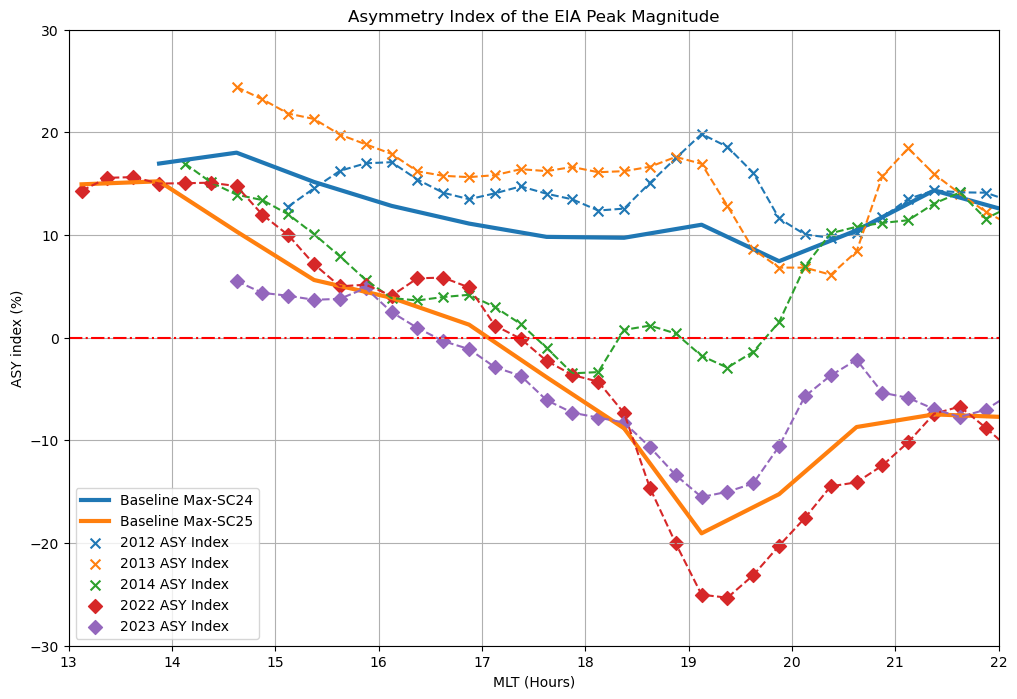

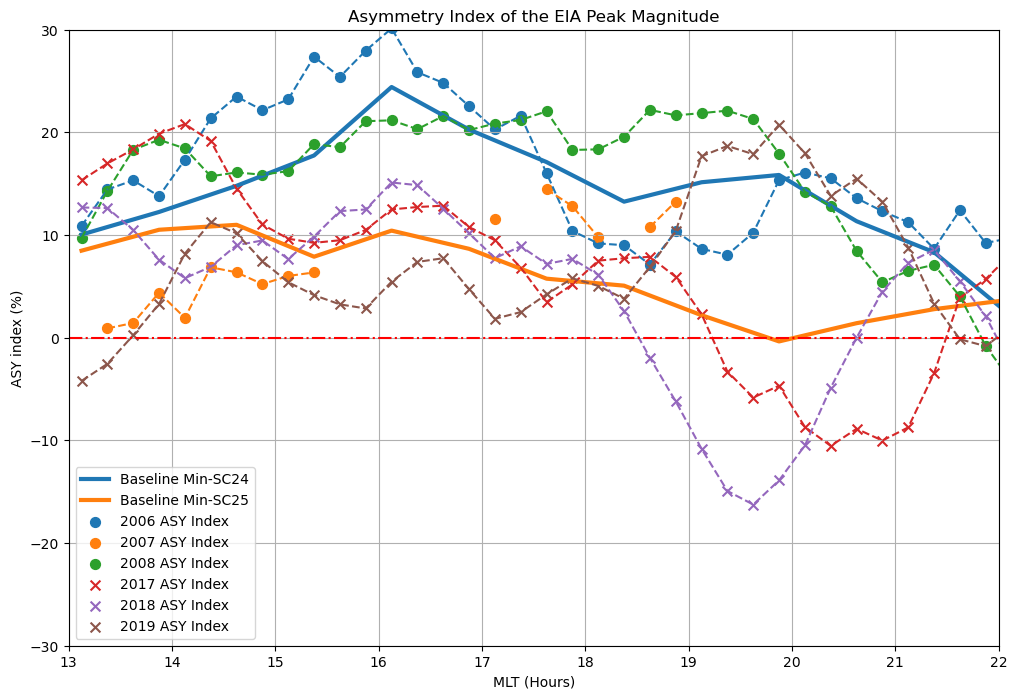

In [7]:
color = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
marker = ['o', 'x', 'D', 's']


# Solar maxima EIAs
fig = plt.figure(figsize=(12,8))
for s, name in zip(sc_base[3:], sc[3:]):
    plt.plot(s.mlt, s.asy, label=name, linewidth=3)
n = 0

for a, y in zip(asy_ind[9:], years[9:]):
    plt.plot(a.mlt, a.asy, linestyle = '--', c = color[n])
    if y < 2011:
        m = marker[0]
    elif y < 2021:
        m = marker[1]
    else:
        m = marker[2]
    plt.scatter(a.mlt, a.asy, marker = m, c = color[n], label=f'{str(y)} ASY Index', s=50)
    n = n + 1

plt.ylim(-30,30)
plt.axhline(y=0, color='red', linestyle='-.')
plt.legend()
plt.title('Asymmetry Index of the EIA Peak Magnitude')
plt.ylabel('ASY index (%)')
plt.xlim(13,22)
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/asy_all_MAX_{month}.jpg')
fig.show()

# Solar minima EIAs
fig = plt.figure(figsize=(12,8))
for s, name in zip(sc_base[:2], sc[:2]):
    plt.plot(s.mlt, s.asy, label=name, linewidth=3)
n = 0

for a, y in zip(asy_ind[:6], years[:6]):
    plt.plot(a.mlt, a.asy, linestyle = '--', c = color[n])
    if y < 2011:
        m = marker[0]
    elif y < 2021:
        m = marker[1]
    else:
        m = marker[2]
    plt.scatter(a.mlt, a.asy, marker = m, c = color[n], label=str(y) + ' ASY Index', s=50)
    n = n + 1

plt.ylim(-30,30)
plt.axhline(y=0, color='red', linestyle='-.')
plt.legend()
plt.title('Asymmetry Index of the EIA Peak Magnitude')
plt.ylabel('ASY index (%)')
plt.xlim(13,22)
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/asy_all_MIN_{month}.jpg')
plt.show()



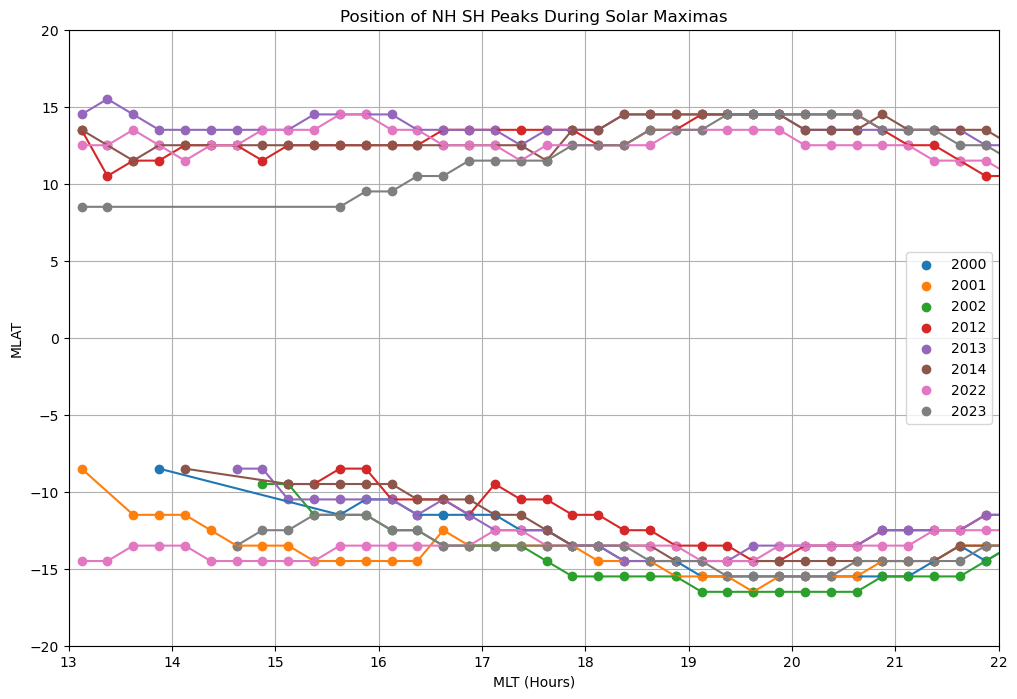

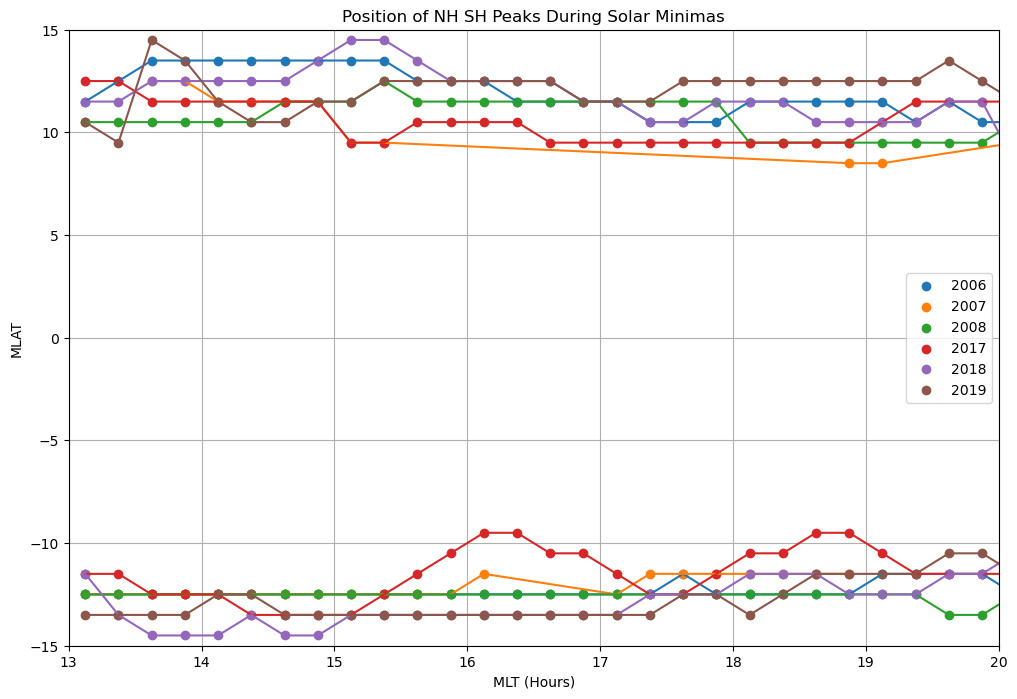

In [8]:
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

# Solar Max Peak Locations
n = 0
fig = plt.figure(figsize=(12,8))
for a, y in zip(asy_ind[6:], years[6:]):
    a_n = a[a.mlat_n > 8].reset_index(drop=True)
    a_s = a[a.mlat_s < -8].reset_index(drop=True)
    if y < 2003:
        mlat = list(a_s.mlat_s)
        time = list(a_s.mlt)
    else:
        mlat = list(a_n.mlat_n) + list(a_s.mlat_s)
        time = list(a_n.mlt) + list(a_s.mlt)
        plt.plot(list(a_n.mlt), list(a_n.mlat_n), c=color[n])
    plt.scatter(time, mlat, c=color[n], label = str(y))
    plt.plot(list(a_s.mlt), list(a_s.mlat_s), c=color[n])
    n = n+1
    
if month == 'june' or month == 'dec':
    plt.ylim(-15,30)
else:
    plt.ylim(-20,20)
plt.xlim(13,22)
plt.legend()
plt.title('Position of NH SH Peaks During Solar Maximas')
plt.ylabel('MLAT')
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/pos_all_MAX_{month}.jpg')
fig.show()


# Solar Min Peak Locations
fig = plt.figure(figsize=(12,8))
n = 0
for a, y in zip(asy_ind[:6], years[:6]):
    a_n = a[a.mlat_n > 8].reset_index(drop=True)
    a_s = a[a.mlat_s < -8].reset_index(drop=True)
    if y < 2003:
        mlat = list(a_s.mlat_s)
        time = list(a_s.mlt)
    else:
        mlat = list(a_n.mlat_n) + list(a_s.mlat_s)
        time = list(a_n.mlt) + list(a_s.mlt)
        plt.plot(list(a_s.mlt), list(a_s.mlat_s), c=color[n])
    plt.scatter(time, mlat, c = color[n], label=str(y))
    plt.plot(list(a_n.mlt), list(a_n.mlat_n), c=color[n])
    n = n + 1

if month == 'june' or month == 'dec':
    plt.ylim(-20, 30)
else:
    plt.ylim(-15,15)
plt.xlim(13,20)
plt.legend()
plt.title('Position of NH SH Peaks During Solar Minimas')
plt.ylabel('MLAT')
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/pos_all_MIN_{month}.jpg')
plt.show()
